In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
import pandas as pd

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
%run functions.ipynb

In [7]:
exam_id = 10
MASKS_DIR = f"/Storage/PauloOctavioDir/Exames/{exam_id}/Segmentado/dcm"
IMAGES_DIR = f"/Storage/PauloOctavioDir/Exames/{exam_id}/dicomRT/Original-dcm"

In [8]:
masks_files = os.listdir(MASKS_DIR)
print(f"Masks files size: {len(masks_files)}")
images_files = os.listdir(IMAGES_DIR)
print(f"Images files size: {len(images_files)}")

Masks files size: 341
Images files size: 342


In [9]:
exam_id = 1
exam, masks_vol = get_volumes("/dicomRT/Original-dcm", "/Segmentado/dcm", exam_id)

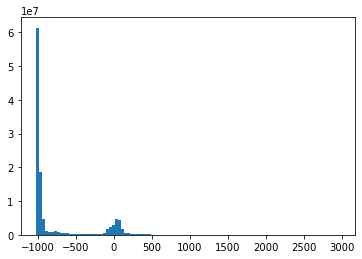

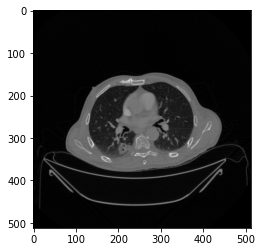

In [10]:
# Show histogram of image values
plt.hist(exam.flatten(), bins=100)
plt.show()

# Show some slice in the middle
plt.imshow(exam[200], cmap=plt.cm.gray)
plt.show()

In [11]:
def sample_stack(stack, rows=8, cols=8, start_with=50, show_every=5):
    fig, ax = plt.subplots(rows, cols, figsize=[18, 20])
    for i in range(rows * cols):
        ind = start_with + i * show_every
        ax[int(i / rows), int(i % rows)].set_title(f"slice {ind}")
        ax[int(i / rows), int(i % rows)].imshow(stack[ind], cmap="gray")
        ax[int(i / rows), int(i % rows)].axis("off")
    plt.show()

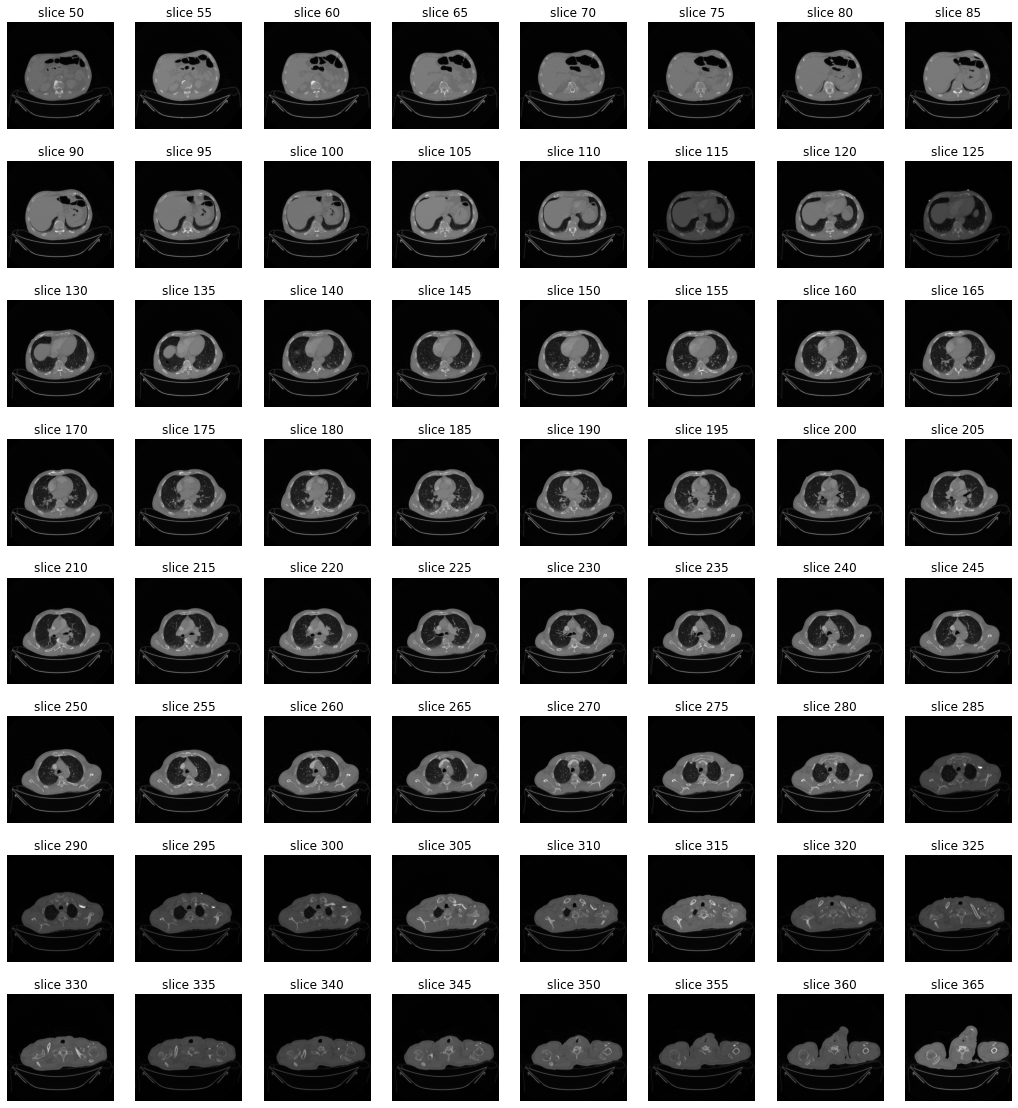

In [12]:
sample_stack(exam)

In [13]:
def plot_3d(image, threshold):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [14]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_lung_mask(image, treshold, fill_lung_structures=True):

    # not actually binary, but 1 and 2.
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > treshold, dtype=np.int8) + 1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air
    #   around the person in half
    background_label = labels[0, 0, 0]

    # Fill the air around the person
    binary_image[background_label == labels] = 2

    # Method of filling the lung structures (that is superior to something like
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None:  # This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    binary_image -= 1  # Make the image actual binary
    binary_image = 1 - binary_image  # Invert it, lungs are now 1

    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:  # There are air pockets
        binary_image[labels != l_max] = 0

    return binary_image

In [15]:
segmented_lungs = segment_lung_mask(exam, treshold=-250)

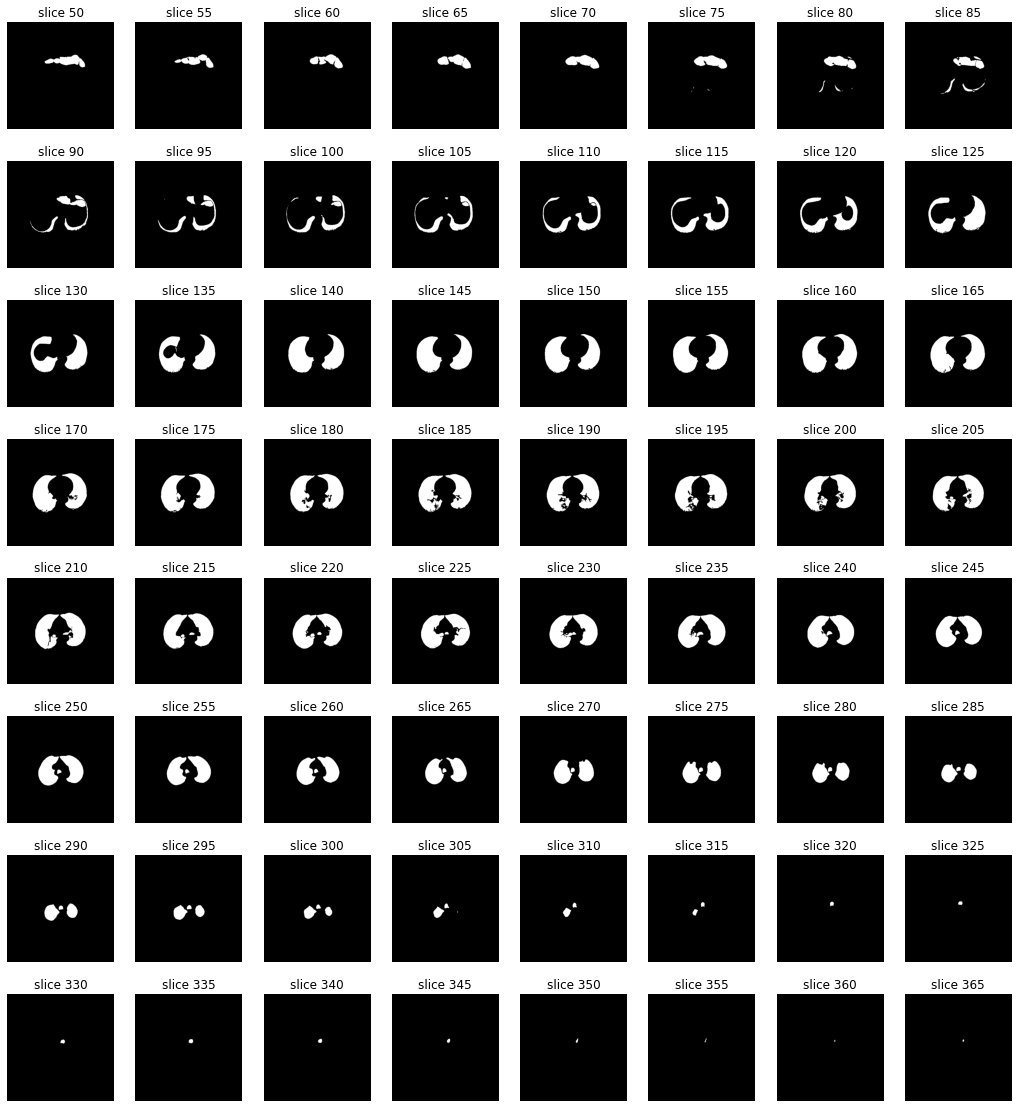

In [16]:
sample_stack(segmented_lungs)

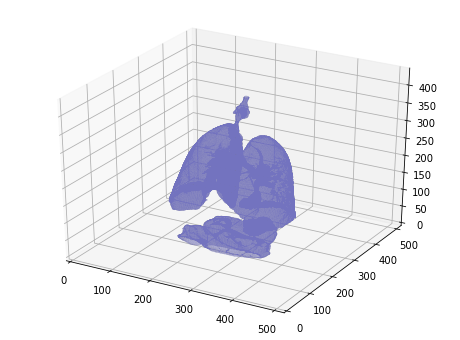

In [17]:
plot_3d(segmented_lungs, 0)

In [18]:
df = pd.read_csv(
    "data/lung_neoplasm_database_cleaned_ds.csv", dtype=object, index_col=0
)
df.head()

,REG EXAME,DATA NASCIMENTO,SEXO,TABAGISMO PREGRESSO,DATA TC,TECNICA TC,LOBO DA LESÃO,POSIÇÃO DA LESÃO,MAIOR DIÂMETRO,ESTADIO T,ESTADIO N,ESTADIO M,DATA 1o DIAGN PATOLÓGICO,TIPO PATOLOGIA (FINAL),TIPO HISTOLÓGICO,DATA PROGRESSÃO DOENÇA,LOCAL DA PROGRESSÃO
0,1,1947-08-19,masc,X,2017-03-02,MDTC contraste,LID,periférica,30,2a,0,1c,2017-08-02,NaN,NSCLC adeno,NaN,NaN
1,2,1946-01-25,masc,X,2015-10-26,MDTC contraste,Lin,periférica,23,1b,0,1c,2015-08-12,biópsia percutânea,NSCLC adeno,2016-06-29,1
2,3,1942-07-30,fem,X,2016-03-14,MDTC contraste,LSD,periférica,11,1a,0,0,2016-04-13,biópsia percutânea,NSCLC adeno,2017-07-18,"5, 8, 6"
3,4,1952-06-28,fem,X,2017-02-21,MDTC contraste,LSD,periférica,16,1a,3,0,2017-02-22,NaN,NSCLC escamoso,2018-05-29,"1, 9"
4,5,1943-02-12,masc,X,2012-03-10,MDTC contraste,LSE,periférica,36,2a,1,0,2012-09-19,cirurgia,Large cell,2016-05-18,1


In [22]:
hist_type = df[df["REG EXAME"] == str(exam_id)]["TIPO HISTOLÓGICO"].values[0]

In [23]:
threshold = 0
p2 = masks_vol.transpose(2, 1, 0)
p1 = segmented_lungs.transpose(2, 1, 0)

lung_verts, lung_faces, _, _ = measure.marching_cubes(p1, threshold)
nodule_verts, nodule_faces, _, _ = measure.marching_cubes(p2, threshold)

In [1]:
lung_x, lung_y, lung_z = zip(*lung_verts)
lung_i, lung_j, lung_k = zip(*lung_faces)

fig = go.Figure(
    data=[
        go.Mesh3d(
            x=lung_x,
            y=lung_y,
            z=lung_z,
            color="lightblue",
            opacity=0.3,
            i=lung_i,
            j=lung_j,
            k=lung_k,
        )
    ]
)

nodule_i, nodule_j, nodule_k = zip(*nodule_faces)
nodule_x, nodule_y, nodule_z = zip(*nodule_verts)
fig.add_trace(
    go.Mesh3d(
        x=nodule_x,
        y=nodule_y,
        z=nodule_z,
        color="lightpink",
        opacity=0.8,
        i=nodule_i,
        j=nodule_j,
        k=nodule_k,
    )
)

fig.update_layout(title=f"Exame #{exam_id} - Tipo Histológico: {hist_type}")
fig.show()